In [1]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the Stroke Prediction Dataset from kaggle
stroke = pd.read_csv('healthcare-dataset-stroke-data.csv')
stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
# Exploratory Data Analysis
# First, let us make sure there are no missing values or NANs in the dataset
print(stroke.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [4]:
# bmi has NAN values. Let us replace all NAN bmi values with the mean bmi
stroke['bmi'] = stroke['bmi'].fillna(stroke['bmi'].mean())
print(stroke.isnull().sum())

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [5]:
# Now, we need to replace the categegorical features with numbers
stroke = stroke.replace(to_replace=['Male', 'Female', 'Other', 'No', 'Yes', 'children', 'Govt_job', 'Never_worked', 'Private', 'Self-employed', 'Rural', 'Urban', 'formerly smoked', 'never smoked', 'smokes', 'Unknown'], value=[0, 1, 2, 0, 1, 0, 1, 2, 3, 4, 0, 1, 0, 1, 2, 3])
stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,1,3,1,228.69,36.600000,0,1
1,51676,1,61.0,0,0,1,4,0,202.21,28.893237,1,1
2,31112,0,80.0,0,1,1,3,0,105.92,32.500000,1,1
3,60182,1,49.0,0,0,1,3,1,171.23,34.400000,2,1
4,1665,1,79.0,1,0,1,4,0,174.12,24.000000,1,1


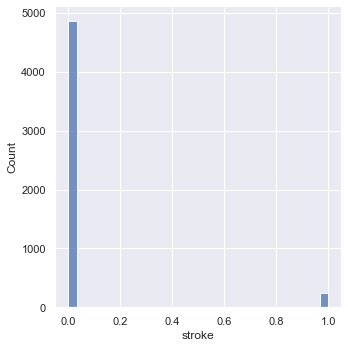

(5110, 12)

In [6]:
# Next, let us plot the target variable stroke
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.displot(stroke['stroke'], bins=30)
plt.show()
stroke.shape

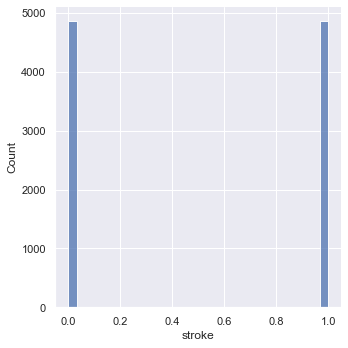

(9722, 12)

In [7]:
# The dataset is extremely imbalanced, so we need to do some resampling
# The resampling technique we will use is called oversampling, which we will perform using SMOTE
# I chose to utilize oversampling over undersampling, since undersampling would yield only 498 samples
from imblearn.over_sampling import SMOTE

# Resamples all classes but the majority class
sm = SMOTE(sampling_strategy='auto', random_state=5)

# Perform the resampling on the dataset
sm_X, sm_Y = sm.fit_resample(stroke.drop(columns=['stroke']), stroke['stroke'])
sm_stroke = pd.concat([sm_X, sm_Y], axis=1)
sm_stroke.columns = stroke.columns
stroke = sm_stroke

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.displot(stroke['stroke'], bins=30)
plt.show()
stroke.shape

<AxesSubplot:>

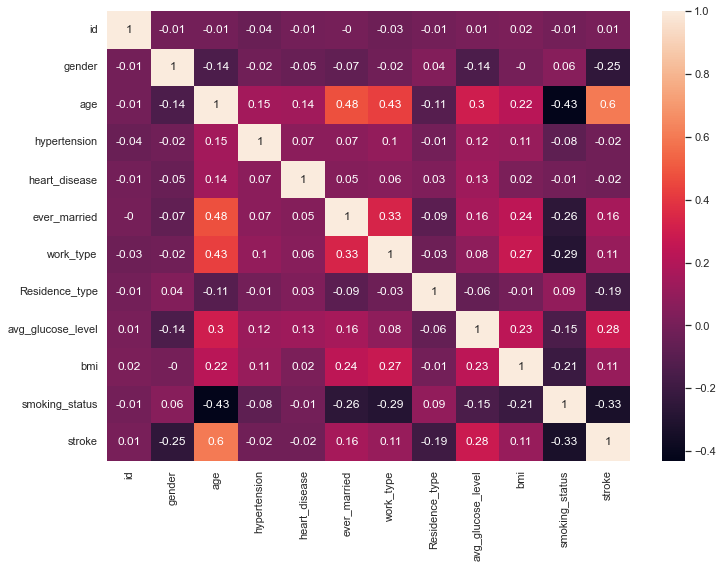

In [8]:
# Finally, let us get the correlation matrix
correlation_matrix = stroke.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

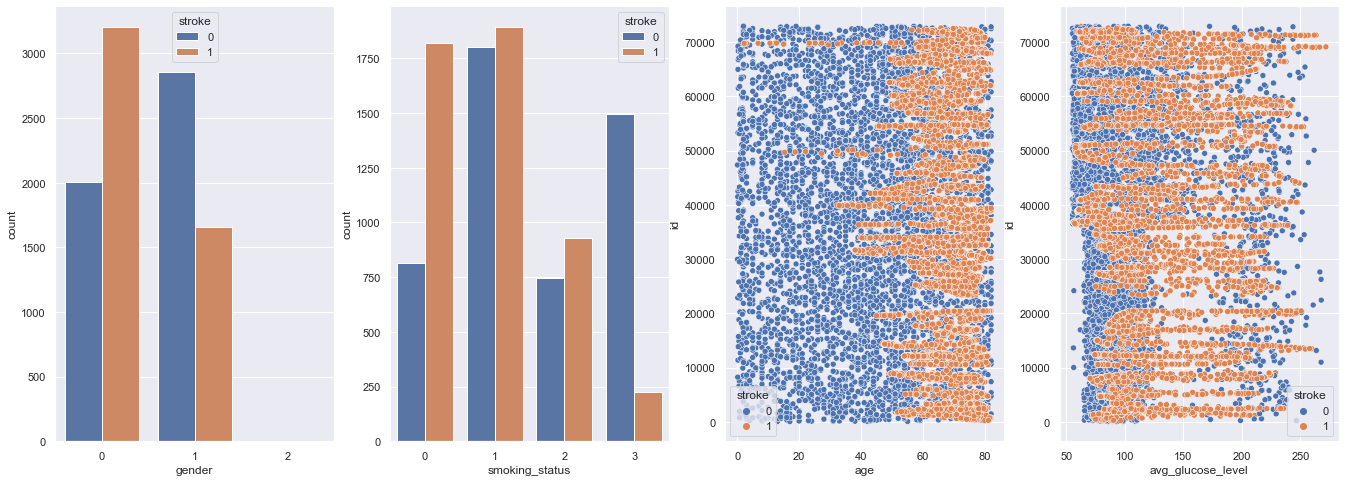

In [9]:
# Let us take the features with the highest correlation scores and see how they relate to the target in a 1D plot
plt.figure(figsize=(23, 8))

plt.subplot(1, 4, 1)
sns.countplot(x='gender', hue='stroke', data=stroke)
plt.subplot(1, 4, 2)
sns.countplot(x='smoking_status', hue='stroke', data=stroke)
plt.subplot(1, 4, 3)
sns.scatterplot(x='age', y='id', hue='stroke', data=stroke)
plt.subplot(1, 4, 4)
sns.scatterplot(x='avg_glucose_level', y='id', hue='stroke', data=stroke)
plt.show()

In [10]:
# Model Analysis
# Now, let us prepare the data for learning
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# Resets X, y to original features
def reset_data():
    X = stroke.to_numpy()
    X = np.delete(X, 11, 1)
    # Let us normalize the features
    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)
    y = stroke['stroke'].to_numpy()
    return X, y

# Resets X, y to the subset of features
def reset_data_less_features():
    # without id
    X = pd.DataFrame(np.c_[stroke['gender'], stroke['age'], stroke['hypertension'], stroke['heart_disease'], stroke['ever_married'], stroke['work_type'], stroke['Residence_type'], stroke['avg_glucose_level'], stroke['bmi'], stroke['smoking_status']], columns = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status'])
    # without id, ever_married, work_type
    #X = pd.DataFrame(np.c_[stroke['gender'], stroke['age'], stroke['hypertension'], stroke['heart_disease'], stroke['Residence_type'], stroke['avg_glucose_level'], stroke['bmi'], stroke['smoking_status']], columns = ['gender', 'age', 'hypertension', 'heart_disease', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status'])
    # without id, hypertension, heart_disease
    #X = pd.DataFrame(np.c_[stroke['gender'], stroke['age'], stroke['ever_married'], stroke['work_type'], stroke['Residence_type'], stroke['avg_glucose_level'], stroke['bmi'], stroke['smoking_status']], columns = ['gender', 'age', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status'])
    # without id, ever_married, work_type, hypertension, heart_disease
    #X = pd.DataFrame(np.c_[stroke['gender'], stroke['age'], stroke['Residence_type'], stroke['avg_glucose_level'], stroke['bmi'], stroke['smoking_status']], columns = ['gender', 'age', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status'])
    y = stroke['stroke']
    X = np.array(X)
    y = np.array(y)
    # Let us normalize the features
    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)
    return X, y

# Performs accuracy, f1, and roc-score metrics
def evaluate_model(model_name, y_train, y_test, y_train_pred, y_test_pred):
    print(model_name + ' Training Accuracy: ' + str(accuracy_score(y_train, y_train_pred)))
    print(model_name + ' Test Accuracy: ' + str(accuracy_score(y_test, y_test_pred)))
    #print(model_name + ' Training Recall score: ' + str(recall_score(y_train, y_train_pred)))
    print(model_name + ' Test Recall score: ' + str(recall_score(y_test, y_test_pred)))
    #print(model_name + ' Test F1 score: ' + str(f1_score(y_test, y_test_pred)))
    #print(model_name + ' Test ROC-AUC score: ' + str(roc_auc_score(y_test, y_test_pred)))

# Split dataset into training set and test set
from sklearn.model_selection import train_test_split
def train_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5) # 70% training and 30% test
    return X_train, X_test, y_train, y_test

In [11]:
# Naive Bayes
# First, let's run the model on all features
X, y = reset_data()
X_train, X_test, y_train, y_test = train_data(X, y)

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB(var_smoothing=1e-9).fit(X_train, y_train)
y_train_pred = gnb.predict(X_train)
y_test_pred = gnb.predict(X_test)
evaluate_model('Gaussian Naive Bayes', y_train, y_test, y_train_pred, y_test_pred)

Gaussian Naive Bayes Training Accuracy: 0.8005878030859662
Gaussian Naive Bayes Test Accuracy: 0.8141926636955776
Gaussian Naive Bayes Test Recall score: 0.884404924760602


In [12]:
# Let us see if a 2-Degree Polynomial will help
from sklearn.preprocessing import PolynomialFeatures
X, y = reset_data()
poly = PolynomialFeatures(2)
X = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_data(X, y)

gnb = GaussianNB(var_smoothing=1e-9).fit(X_train, y_train)
y_train_pred = gnb.predict(X_train)
y_test_pred = gnb.predict(X_test)
evaluate_model('Gaussian Naive Bayes', y_train, y_test, y_train_pred, y_test_pred)

Gaussian Naive Bayes Training Accuracy: 0.6919911829537105
Gaussian Naive Bayes Test Accuracy: 0.7072334590332533
Gaussian Naive Bayes Test Recall score: 0.9001367989056087


In [13]:
# Lastly, let us try using only the most highly correlated features
X, y = reset_data_less_features()
X_train, X_test, y_train, y_test = train_data(X, y)

gnb = GaussianNB(var_smoothing=1e-9).fit(X_train, y_train)
y_train_pred = gnb.predict(X_train)
y_test_pred = gnb.predict(X_test)
evaluate_model('Gaussian Naive Bayes', y_train, y_test, y_train_pred, y_test_pred)

Gaussian Naive Bayes Training Accuracy: 0.8007347538574577
Gaussian Naive Bayes Test Accuracy: 0.8138498457319163
Gaussian Naive Bayes Test Recall score: 0.8837209302325582


In [14]:
# Logistic Regression
# All features
X, y = reset_data()
X_train, X_test, y_train, y_test = train_data(X, y)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l2', C=1, max_iter=10000).fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
evaluate_model('Logistic Regression', y_train, y_test, y_train_pred, y_test_pred)

Logistic Regression Training Accuracy: 0.8255694342395298
Logistic Regression Test Accuracy: 0.8337332876242715
Logistic Regression Test Recall score: 0.8481532147742818


In [15]:
# 2-Degree Polynomial features
X, y = reset_data()
poly = PolynomialFeatures(2)
X = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_data(X, y)

lr = LogisticRegression(penalty='l2', C=1, max_iter=10000).fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
evaluate_model('Logistic Regression', y_train, y_test, y_train_pred, y_test_pred)

Logistic Regression Training Accuracy: 0.858192505510654
Logistic Regression Test Accuracy: 0.85978745286253
Logistic Regression Test Recall score: 0.8816689466484268


In [16]:
# Subset of features
X, y = reset_data_less_features()
X_train, X_test, y_train, y_test = train_data(X, y)

lr = LogisticRegression(penalty='l2', C=1, max_iter=10000).fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
evaluate_model('Logistic Regression', y_train, y_test, y_train_pred, y_test_pred)

Logistic Regression Training Accuracy: 0.8245407788390889
Logistic Regression Test Accuracy: 0.8357901954062393
Logistic Regression Test Recall score: 0.8481532147742818


In [17]:
# K-Nearest Neigbors
from sklearn.neighbors import KNeighborsClassifier
X, y = reset_data()
X_train, X_test, y_train, y_test = train_data(X, y)

# Let's find the ideal value of K
recall = []
for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_test_pred = knn.predict(X_test)
    recall.append(recall_score(y_test, y_test_pred))

Text(0, 0.5, 'Test Recall')

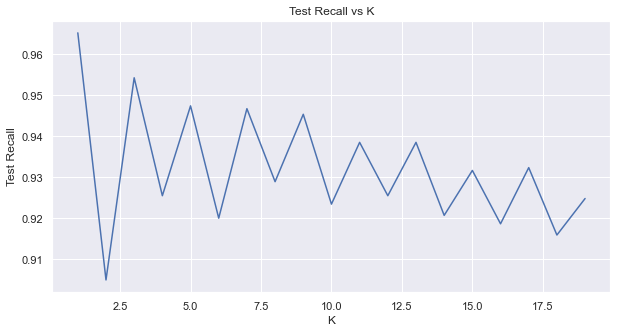

In [18]:
plt.figure(figsize=(10,5))
plt.plot(range(1,20), recall)
plt.title('Test Recall vs K')
plt.xlabel('K')
plt.ylabel('Test Recall')

In [19]:
# All features
X, y = reset_data()
X_train, X_test, y_train, y_test = train_data(X, y)

# the best value of K is 1
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)
evaluate_model('1-Nearest Neighbor', y_train, y_test, y_train_pred, y_test_pred)

1-Nearest Neighbor Training Accuracy: 1.0
1-Nearest Neighbor Test Accuracy: 0.9115529653753857
1-Nearest Neighbor Test Recall score: 0.9651162790697675


In [20]:
# 2-Degree Polynomial features
X, y = reset_data()
poly = PolynomialFeatures(2)
X = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_data(X, y)

knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)
evaluate_model('1-Nearest Neighbor', y_train, y_test, y_train_pred, y_test_pred)

1-Nearest Neighbor Training Accuracy: 1.0
1-Nearest Neighbor Test Accuracy: 0.9098388755570792
1-Nearest Neighbor Test Recall score: 0.9637482900136799


In [21]:
# Subset of features
X, y = reset_data_less_features()
X_train, X_test, y_train, y_test = train_data(X, y)

knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)
evaluate_model('1-Nearest Neighbor', y_train, y_test, y_train_pred, y_test_pred)

1-Nearest Neighbor Training Accuracy: 1.0
1-Nearest Neighbor Test Accuracy: 0.8899554336647241
1-Nearest Neighbor Test Recall score: 0.9302325581395349


In [22]:
# Perceptron
from sklearn.linear_model import Perceptron
X, y = reset_data()
X_train, X_test, y_train, y_test = train_data(X, y)

# Let's find the ideal value of n_iter_no_change
recall = []
for i in range(1, 100):
    clf = Perceptron(alpha=1e-5, n_iter_no_change=i).fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    recall.append(recall_score(y_test, y_test_pred))

Text(0, 0.5, 'Test Recall')

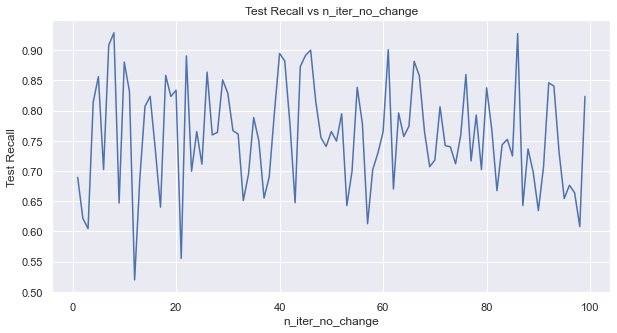

In [23]:
plt.figure(figsize=(10,5))
plt.plot(range(1,100), recall)
plt.title('Test Recall vs n_iter_no_change')
plt.xlabel('n_iter_no_change')
plt.ylabel('Test Recall')

In [24]:
# All features
X, y = reset_data()
X_train, X_test, y_train, y_test = train_data(X, y)

# 8 is the best value for n_iter_no_change
clf = Perceptron(alpha=1e-5, n_iter_no_change=8).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Perceptron', y_train, y_test, y_train_pred, y_test_pred)

Perceptron Training Accuracy: 0.7753122703894195
Perceptron Test Accuracy: 0.7908810421666095
Perceptron Test Recall score: 0.9288645690834473


In [25]:
# Let's find the ideal value of n_iter_no_change for 2-D Polynomial features
X, y = reset_data()
poly = PolynomialFeatures(2)
X = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_data(X, y)

recall = []
for i in range(1, 100):
    clf = Perceptron(alpha=1e-5, n_iter_no_change=i).fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    recall.append(recall_score(y_test, y_test_pred))

Text(0, 0.5, 'Test Recall')

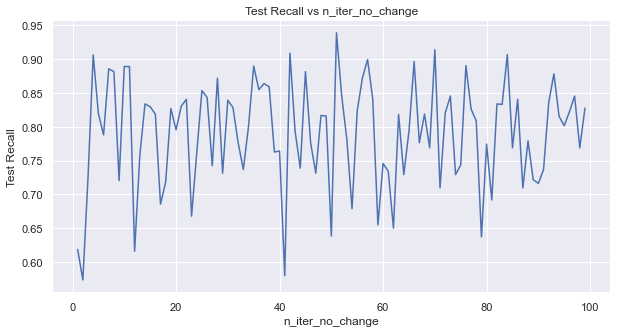

In [26]:
plt.figure(figsize=(10,5))
plt.plot(range(1,100), recall)
plt.title('Test Recall vs n_iter_no_change')
plt.xlabel('n_iter_no_change')
plt.ylabel('Test Recall')

In [27]:
# 2-Degree Polynomial features
X, y = reset_data()
poly = PolynomialFeatures(2)
X = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_data(X, y)

# 51 is the best value for n_iter_no_change
clf = Perceptron(alpha=1e-5, n_iter_no_change=51).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Perceptron', y_train, y_test, y_train_pred, y_test_pred)

Perceptron Training Accuracy: 0.8055841293166789
Perceptron Test Accuracy: 0.8179636612958519
Perceptron Test Recall score: 0.939124487004104


In [28]:
# Subset of features
X, y = reset_data_less_features()
X_train, X_test, y_train, y_test = train_data(X, y)

clf = Perceptron().fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Perceptron', y_train, y_test, y_train_pred, y_test_pred)

Perceptron Training Accuracy: 0.7259368111682586
Perceptron Test Accuracy: 0.7394583476174151
Perceptron Test Recall score: 0.7428180574555403


In [29]:
# Support Vector Machine
# All features
X, y = reset_data()
X_train, X_test, y_train, y_test = train_data(X, y)

from sklearn.svm import SVC
clf = SVC(kernel='poly', degree=5, C=1).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Support Vector Classification', y_train, y_test, y_train_pred, y_test_pred)

Support Vector Classification Training Accuracy: 0.8855253490080823
Support Vector Classification Test Accuracy: 0.8669866300994172
Support Vector Classification Test Recall score: 0.960328317373461


In [30]:
# 2-Degree Polynomial features
X, y = reset_data()
poly = PolynomialFeatures(2)
X = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_data(X, y)

clf = SVC(kernel='poly', degree=5, C=1).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Support Vector Classification', y_train, y_test, y_train_pred, y_test_pred)

Support Vector Classification Training Accuracy: 0.7134459955914768
Support Vector Classification Test Accuracy: 0.6931779225231403
Support Vector Classification Test Recall score: 0.9863201094391245


In [31]:
# Subset of features
X, y = reset_data_less_features()
X_train, X_test, y_train, y_test = train_data(X, y)

clf = SVC(kernel='poly', degree=5, C=1).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Support Vector Classification', y_train, y_test, y_train_pred, y_test_pred)

Support Vector Classification Training Accuracy: 0.8689199118295371
Support Vector Classification Test Accuracy: 0.8519026396983201
Support Vector Classification Test Recall score: 0.9514363885088919


In [32]:
# Decision Tree
from sklearn import tree
X, y = reset_data()
X_train, X_test, y_train, y_test = train_data(X, y)

# Let's find the ideal value of max_depth
recall = []
for i in range(1, 100):
    clf = tree.DecisionTreeClassifier(max_depth=i, random_state=5).fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    recall.append(recall_score(y_test, y_test_pred))

Text(0, 0.5, 'Test Recall')

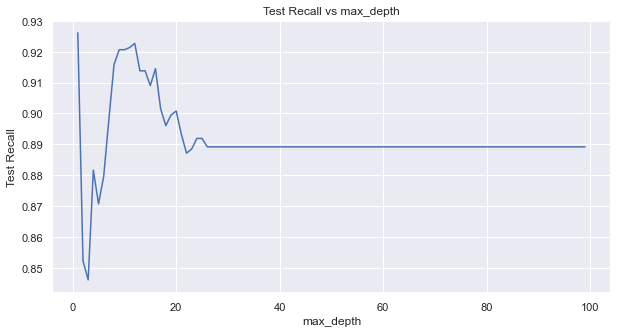

In [33]:
plt.figure(figsize=(10,5))
plt.plot(range(1,100), recall)
plt.title('Test Recall vs max_depth')
plt.xlabel('max_depth')
plt.ylabel('Test Recall')

In [34]:
# All features
X, y = reset_data()
X_train, X_test, y_train, y_test = train_data(X, y)

# 1 is the best value for max_depth
clf = tree.DecisionTreeClassifier(max_depth=1, random_state=5).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Decision Tree', y_train, y_test, y_train_pred, y_test_pred)

Decision Tree Training Accuracy: 0.7844232182218956
Decision Tree Test Accuracy: 0.8021940349674322
Decision Tree Test Recall score: 0.9261285909712722


In [35]:
# Let's find the ideal value of max_depth for 2-Degree Polynomial features
X, y = reset_data()
poly = PolynomialFeatures(2)
X = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_data(X, y)

recall = []
for i in range(1, 100):
    clf = tree.DecisionTreeClassifier(max_depth=i, random_state=5).fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    recall.append(recall_score(y_test, y_test_pred))

Text(0, 0.5, 'Test Recall')

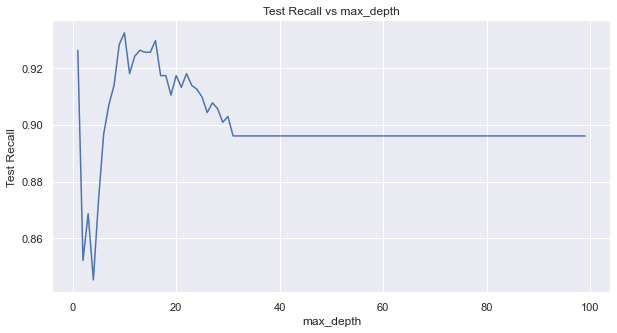

In [36]:
plt.figure(figsize=(10,5))
plt.plot(range(1,100), recall)
plt.title('Test Recall vs max_depth')
plt.xlabel('max_depth')
plt.ylabel('Test Recall')

In [37]:
# 2-Degree Polynomial features
X, y = reset_data()
poly = PolynomialFeatures(2)
X = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_data(X, y)

# 13 is the best value for max_depth
clf = tree.DecisionTreeClassifier(max_depth=13, random_state=5).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Decision Tree', y_train, y_test, y_train_pred, y_test_pred)

Decision Tree Training Accuracy: 0.9672299779573843
Decision Tree Test Accuracy: 0.8961261570106274
Decision Tree Test Recall score: 0.9261285909712722


In [38]:
# Subset of features
X, y = reset_data_less_features()
X_train, X_test, y_train, y_test = train_data(X, y)

clf = tree.DecisionTreeClassifier(random_state=5).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Decision Tree', y_train, y_test, y_train_pred, y_test_pred)

Decision Tree Training Accuracy: 1.0
Decision Tree Test Accuracy: 0.8700719917723688
Decision Tree Test Recall score: 0.8693570451436389


In [39]:
# Bagging (Bootstrap Aggregation) Decision Tree
# All features
X, y = reset_data()
X_train, X_test, y_train, y_test = train_data(X, y)

from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(max_samples=1, max_features=1, base_estimator=tree.DecisionTreeClassifier(random_state=5), random_state=5).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Bagging Decision Tree', y_train, y_test, y_train_pred, y_test_pred)

Bagging Decision Tree Training Accuracy: 0.5005143277002204
Bagging Decision Tree Test Accuracy: 0.49880013712718546
Bagging Decision Tree Test Recall score: 0.0


In [40]:
# 2-Degree Polynomial features
X, y = reset_data()
poly = PolynomialFeatures(2)
X = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_data(X, y)

clf = BaggingClassifier(max_samples=1, max_features=1, base_estimator=tree.DecisionTreeClassifier(random_state=5), random_state=5).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Bagging Decision Tree', y_train, y_test, y_train_pred, y_test_pred)

Bagging Decision Tree Training Accuracy: 0.5005143277002204
Bagging Decision Tree Test Accuracy: 0.49880013712718546
Bagging Decision Tree Test Recall score: 0.0


In [41]:
# Subset of features
X, y = reset_data_less_features()
X_train, X_test, y_train, y_test = train_data(X, y)

clf = BaggingClassifier(max_samples=1, max_features=1, base_estimator=tree.DecisionTreeClassifier(random_state=5), random_state=5).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Bagging Decision Tree', y_train, y_test, y_train_pred, y_test_pred)

Bagging Decision Tree Training Accuracy: 0.5005143277002204
Bagging Decision Tree Test Accuracy: 0.49880013712718546
Bagging Decision Tree Test Recall score: 0.0


In [42]:
# Adaboost
# All features
X, y = reset_data()
X_train, X_test, y_train, y_test = train_data(X, y)

from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(learning_rate=1, base_estimator=tree.DecisionTreeClassifier(random_state=5), random_state=5).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Adaboost', y_train, y_test, y_train_pred, y_test_pred)

Adaboost Training Accuracy: 1.0
Adaboost Test Accuracy: 0.8817278025368529
Adaboost Test Recall score: 0.8926128590971272


In [43]:
# 2-Degree Polynomial features
X, y = reset_data()
poly = PolynomialFeatures(2)
X = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_data(X, y)

clf = AdaBoostClassifier(learning_rate=1, base_estimator=tree.DecisionTreeClassifier(random_state=5), random_state=5).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Adaboost', y_train, y_test, y_train_pred, y_test_pred)

Adaboost Training Accuracy: 1.0
Adaboost Test Accuracy: 0.8865272540281111
Adaboost Test Recall score: 0.9008207934336525


In [44]:
# Subset of features
X, y = reset_data_less_features()
X_train, X_test, y_train, y_test = train_data(X, y)

clf = AdaBoostClassifier(learning_rate=1, base_estimator=tree.DecisionTreeClassifier(random_state=5), random_state=5).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Adaboost', y_train, y_test, y_train_pred, y_test_pred)

Adaboost Training Accuracy: 1.0
Adaboost Test Accuracy: 0.8666438121357559
Adaboost Test Recall score: 0.8666210670314638


In [45]:
# Gradient Boosted Decision Tree
from sklearn.ensemble import GradientBoostingClassifier
X, y = reset_data()
X_train, X_test, y_train, y_test = train_data(X, y)

# Let's find the ideal value of max_depth
recall = []
for i in range(1, 20):
    clf = GradientBoostingClassifier(max_depth=i, learning_rate=0.1, random_state=5).fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    recall.append(recall_score(y_test, y_test_pred))

Text(0, 0.5, 'Test Recall')

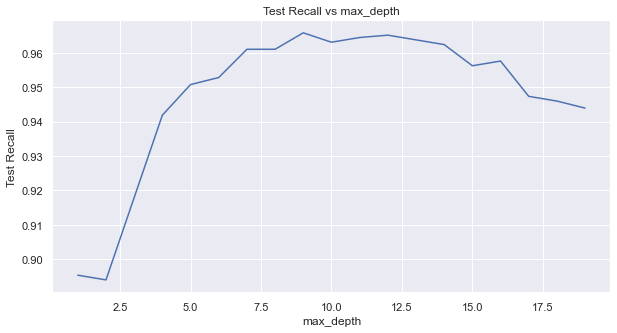

In [46]:
plt.figure(figsize=(10,5))
plt.plot(range(1,20), recall)
plt.title('Test Recall vs max_depth')
plt.xlabel('max_depth')
plt.ylabel('Test Recall')

In [47]:
# All features
X, y = reset_data()
X_train, X_test, y_train, y_test = train_data(X, y)

# 9 is the best value for max_depth
clf = GradientBoostingClassifier(max_depth=9, learning_rate=0.1, random_state=5).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Gradient Boosted Decision Trees', y_train, y_test, y_train_pred, y_test_pred)

Gradient Boosted Decision Trees Training Accuracy: 1.0
Gradient Boosted Decision Trees Test Accuracy: 0.9544052108330476
Gradient Boosted Decision Trees Test Recall score: 0.9658002735978112


In [48]:
# Let's find the ideal value of max_depth for 2-Degree Polynomial features
X, y = reset_data()
poly = PolynomialFeatures(2)
X = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_data(X, y)

recall = []
for i in range(1, 20):
    clf = GradientBoostingClassifier(max_depth=i, learning_rate=0.1, random_state=5).fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    recall.append(recall_score(y_test, y_test_pred))

Text(0, 0.5, 'Test Recall')

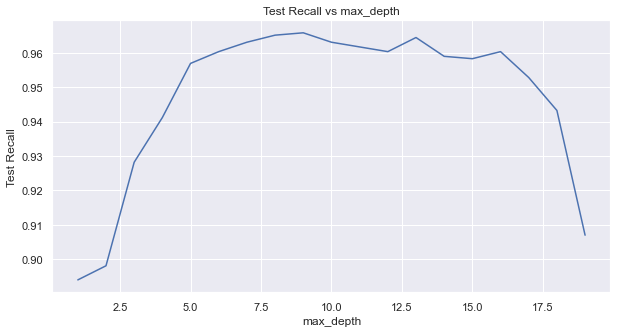

In [49]:
plt.figure(figsize=(10,5))
plt.plot(range(1,20), recall)
plt.title('Test Recall vs max_depth')
plt.xlabel('max_depth')
plt.ylabel('Test Recall')

In [50]:
# 2-Degree Polynomial features
X, y = reset_data()
poly = PolynomialFeatures(2)
X = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_data(X, y)

# 9 is the best value for max_depth
clf = GradientBoostingClassifier(max_depth=9, learning_rate=0.1, random_state=5).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Gradient Boosted Decision Trees', y_train, y_test, y_train_pred, y_test_pred)

Gradient Boosted Decision Trees Training Accuracy: 1.0
Gradient Boosted Decision Trees Test Accuracy: 0.951319849160096
Gradient Boosted Decision Trees Test Recall score: 0.9658002735978112


In [51]:
# Subset of features
X, y = reset_data_less_features()
X_train, X_test, y_train, y_test = train_data(X, y)

clf = GradientBoostingClassifier(learning_rate=0.1, random_state=5).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Gradient Boosted Decision Trees', y_train, y_test, y_train_pred, y_test_pred)

Gradient Boosted Decision Trees Training Accuracy: 0.8890521675238795
Gradient Boosted Decision Trees Test Accuracy: 0.8810421666095304
Gradient Boosted Decision Trees Test Recall score: 0.9015047879616963


In [52]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
X, y = reset_data()
X_train, X_test, y_train, y_test = train_data(X, y)

# Let's find the ideal value of max_depth
recall = []
for i in range(1, 20):
    clf = RandomForestClassifier(max_depth=i, random_state=5).fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    recall.append(recall_score(y_test, y_test_pred))

Text(0, 0.5, 'Test Recall')

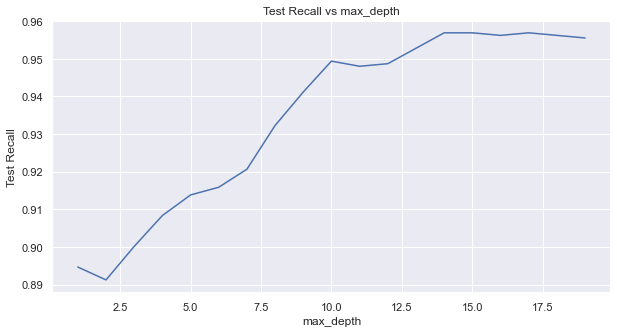

In [53]:
plt.figure(figsize=(10,5))
plt.plot(range(1,20), recall)
plt.title('Test Recall vs max_depth')
plt.xlabel('max_depth')
plt.ylabel('Test Recall')

In [54]:
# All features
X, y = reset_data()
X_train, X_test, y_train, y_test = train_data(X, y)

# 15 is the best value for max_depth
clf = RandomForestClassifier(max_depth=15, random_state=5).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Random Forest', y_train, y_test, y_train_pred, y_test_pred)

Random Forest Training Accuracy: 0.9875091844232182
Random Forest Test Accuracy: 0.9321220431950634
Random Forest Test Recall score: 0.9569083447332422


In [55]:
# Let's find the ideal value of max_depth for 2-Degree Polynomial features
X, y = reset_data()
poly = PolynomialFeatures(2)
X = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_data(X, y)

recall = []
for i in range(1, 20):
    clf = RandomForestClassifier(max_depth=i, random_state=5).fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    recall.append(recall_score(y_test, y_test_pred))

Text(0, 0.5, 'Test Recall')

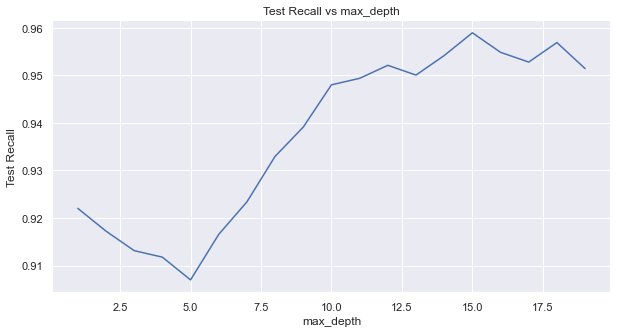

In [56]:
plt.figure(figsize=(10,5))
plt.plot(range(1,20), recall)
plt.title('Test Recall vs max_depth')
plt.xlabel('max_depth')
plt.ylabel('Test Recall')

In [57]:
# 2-Degree Polynomial features
X, y = reset_data()
poly = PolynomialFeatures(2)
X = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_data(X, y)

# 15 is the best value for max_depth
clf = RandomForestClassifier(max_depth=15, random_state=5).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Random Forest', y_train, y_test, y_train_pred, y_test_pred)

Random Forest Training Accuracy: 0.9866274797942689
Random Forest Test Accuracy: 0.9331504970860474
Random Forest Test Recall score: 0.9589603283173734


In [58]:
# Subset of features
X, y = reset_data_less_features()
X_train, X_test, y_train, y_test = train_data(X, y)

clf = RandomForestClassifier(random_state=5).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Random Forest', y_train, y_test, y_train_pred, y_test_pred)

Random Forest Training Accuracy: 1.0
Random Forest Test Accuracy: 0.917723688721289
Random Forest Test Recall score: 0.9295485636114911


In [59]:
# Neural Network (Multi-Layer Perceptron)
# All features
X, y = reset_data()
X_train, X_test, y_train, y_test = train_data(X, y)

from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(max_iter=1000, alpha=1e-5, random_state=5).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Neural Network', y_train, y_test, y_train_pred, y_test_pred)

Neural Network Training Accuracy: 0.9362233651726671
Neural Network Test Accuracy: 0.9115529653753857
Neural Network Test Recall score: 0.9377564979480164


In [60]:
# 2-Degree Polynomial features
X, y = reset_data()
poly = PolynomialFeatures(2)
X = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_data(X, y)

clf = MLPClassifier(max_iter=1000, alpha=1e-5, random_state=5).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Neural Network', y_train, y_test, y_train_pred, y_test_pred)

Neural Network Training Accuracy: 0.9801616458486407
Neural Network Test Accuracy: 0.9170380527939664
Neural Network Test Recall score: 0.9418604651162791


In [61]:
# Subset of features
X, y = reset_data_less_features()
X_train, X_test, y_train, y_test = train_data(X, y)

clf = MLPClassifier(max_iter=1000, alpha=1e-5, random_state=5).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
evaluate_model('Neural Network', y_train, y_test, y_train_pred, y_test_pred)

Neural Network Training Accuracy: 0.9108008817046289
Neural Network Test Accuracy: 0.8923551594103531
Neural Network Test Recall score: 0.9186046511627907


In [62]:
# Final Phase of Testing
# Creating 2-Degree Polynomial features with a randomized train/test split
def poly_features_randomized_split():
    X, y = reset_data()
    poly = PolynomialFeatures(2)
    X = poly.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # no random_state
    return X_train, X_test, y_train, y_test

In [63]:
# Let us use all 2-Degree Polynomial Models with a Test Recall of over 0.95
# 1-Nearest Neighbor, Support Vector Machine, Gradient Boosted Decision Tree, and Random Forest
# Now let's run each model 20 times and store the Test Recall values
KNN_recall, SVM_recall, GBDT_recall, RF_recall = [], [], [], []

for i in range(0,20):
    # Initialize data
    X_train, X_test, y_train, y_test = poly_features_randomized_split()
    
    # Train and Test using 1-NN
    knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
    y_test_pred = knn.predict(X_test)
    KNN_recall.append(recall_score(y_test, y_test_pred))
    
    # Train and Test using SVM
    clf = SVC(kernel='poly', degree=5, C=1).fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    SVM_recall.append(recall_score(y_test, y_test_pred))
    
    # Train and Test using GBDT
    clf = GradientBoostingClassifier(max_depth=9, learning_rate=0.1, random_state=5).fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    GBDT_recall.append(recall_score(y_test, y_test_pred))
    
    # Train and Test using RF
    clf = RandomForestClassifier(max_depth=15, random_state=5).fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    RF_recall.append(recall_score(y_test, y_test_pred))

In [64]:
# Now, let us calculate the mean and standard deviation test recall for each model
KNN_mean, KNN_std = np.mean(KNN_recall), np.std(KNN_recall)
SVM_mean, SVM_std = np.mean(SVM_recall), np.std(SVM_recall)
GBDT_mean, GBDT_std = np.mean(GBDT_recall), np.std(GBDT_recall)
RF_mean, RF_std = np.mean(RF_recall), np.std(RF_recall)
print('1-Nearest Neighbor. Mean = ' + str(KNN_mean) + '. Standard Deviation = ' + str(KNN_std) + '.')
print('Support Vector Machine. Mean = ' + str(SVM_mean) + '. Standard Deviation = ' + str(SVM_std) + '.')
print('Gradient Boosted Decision Tree. Mean = ' + str(GBDT_mean) + '. Standard Deviation = ' + str(GBDT_std) + '.')
print('Random Forest. Mean = ' + str(RF_mean) + '. Standard Deviation = ' + str(RF_std) + '.')

1-Nearest Neighbor. Mean = 0.9523739442430477. Standard Deviation = 0.004607465263491852.
Support Vector Machine. Mean = 0.9860049538859602. Standard Deviation = 0.0027046977015742187.
Gradient Boosted Decision Tree. Mean = 0.964095099863389. Standard Deviation = 0.003686819114381265.
Random Forest. Mean = 0.9565367743713414. Standard Deviation = 0.003943585827302667.


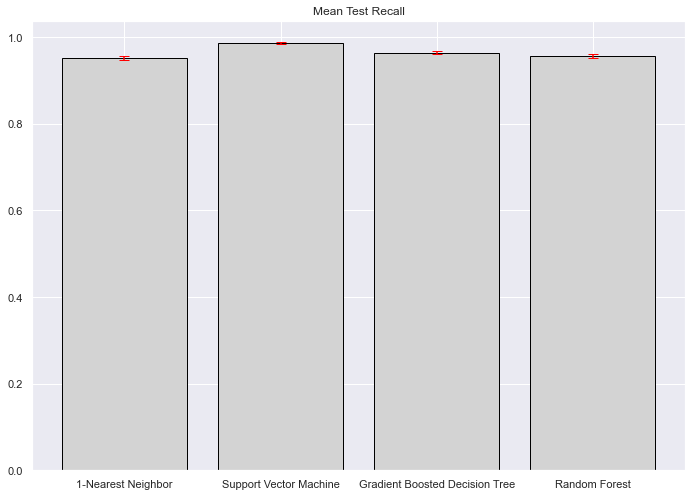

In [65]:
# Finally, let us plot the mean test recall with standard deviation error bars
model_names = ['1-Nearest Neighbor', 'Support Vector Machine', 'Gradient Boosted Decision Tree', 'Random Forest']
mean_values = [KNN_mean, SVM_mean, GBDT_mean, RF_mean]
std_values = [KNN_std, SVM_std, GBDT_std, RF_std]

plt.bar(model_names, mean_values, yerr=std_values, color='lightgray', ec='black', ecolor='red', capsize=5)
plt.title('Mean Test Recall')
plt.show()

In [66]:
# Task Specific Metric
# How would the model perform in the real world? What do these results mean?

# Using the mean test recall for the best model (Support Vector Machine)
pos_stroke = X.shape[0]/2
print('On average, ' + str(int(np.floor(pos_stroke*SVM_mean))) + ' actual strokes were correctly predicted.')
print('On average, ' + str(int(pos_stroke-np.floor(pos_stroke*SVM_mean))) + ' actual strokes were incorrectly predicted.')

On average, 4792 actual strokes were correctly predicted.
On average, 69 actual strokes were incorrectly predicted.


In [67]:
# Does the model perform suspiciously too well?
# Let us use the same method as before to compute the test accuracy mean and standard deviation
SVM_accuracy = []

for i in range(0,20):
    # Initialize data
    X_train, X_test, y_train, y_test = poly_features_randomized_split()
    
    # Train and Test using SVM
    clf = SVC(kernel='poly', degree=5, C=1).fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    SVM_accuracy.append(accuracy_score(y_test, y_test_pred))

In [68]:
print('Support Vector Machine Test Accuracy.')
print('Mean = ' + str(np.mean(SVM_accuracy)) + '. Standard Deviation = ' + str(np.std(SVM_accuracy)) + '.')

Support Vector Machine Test Accuracy.
Mean = 0.684658896126157. Standard Deviation = 0.00830460154237787.
